# Classification Modeling for Hazardous Rip Current Prediction

 * Creators: Andre van der Westhuysen<sup>1</sup>, Gregory Dusek<sup>2</sup>, Jung-Sun Im<sup>3</sup>, Mike Churma<sup>3</sup>, and John F. Kuhn<sup>4</sup>, Saeideh Banihashemi<sup>1</sup>
 * Affiliations: <sup>1</sup>NOAA/NWS/NCEP Environmental Modeling Center, <sup>2</sup>NOAA/NOS/CO-OPS, <sup>3</sup>NOAA/NWS/Meteorological Development Lab, <sup>4</sup>NOAA/NWS/Analyze, Forecast and Support Office
 * History:
   * Version 1, Published on 2024-09-24

## Time Estimate
 - Estimated text reading time: 13 to 25 min
 - Estimated code reading time: 12 to 24 min
 - Estimated total reading time: 25 to 49 min

---


## Overview
This notebook explores binomial (two classes) classification modeling, using an application example of the prediction of hazardous rip currents in San Diego, CA. Rip currents are the leading source of drownings on U.S. beaches, with approaximately 100 fatalies per year [(you can learn more about rip currents at the NOAA NWS Rip Current Page)](https://www.weather.gov/safety/ripcurrent). However, it is computationally expensive to predict rip currents using traditional physics-based models that resolve the detailed fluid dynamics that lead to rip current formation. Further, the highly location specific data such as detailed surf zone bathymetry (i.e. the shape of the bottom nearshore) necessary to run these physics-based models is generally not available, making a national implementation of a physics-based approach challenging. Instead, turning the prediction problem into a classification task using machine learning (ML) methods enables incoporating information from physics-based wave and water level models to predict the likelihood of hazardous rip current occurrence. This approach provides actionable guidance to NOAA forecasters at relatively low computational cost and can be run as a national model.

### Prerequisites
The student is assumed to have a basic understanding of statistics, in particular of linear regression. Fluency in Python and data manupulation with Pandas is assumed.

### Learning Outcomes
From this notebook, the student will learn:
- How a geophysical modeling task can be restated as a classification problem, and how it can be solved using different ML models.
- How to collect, clean, and transform the environmental data needed to solve the classification problem.
- How to compare the quality of different classification models.
- How to set a probability threshold for identifying events, based on a trade-off between precision and recall.

Upon completion of this training, the student will be able to:
- Identify when a given geophysical problem can be cast as a classification problem.
- Locate, load and manipulate the necessary data for classification.
- Employ and evaluate different ML models to solve the classification problem.
- Quantify the performance of different ML classification models in terms of practical metrics such as the percentage of positive events detected (recall), and the accuracy rate of positive predictions (precision).

---



## 1. Background
  * Science problem: Bathymetry-driven rip currents are caused by variations in the nearshore bathymetry, causing shoaling waves to break unevenly along the coastline. This results in uneven regions of wave-driven setup, which causes focused return currents, known as rip currents. These phenomena are small scale and can be highly variable in space and time, making them challenging and computationally expensive to predict with traditional physics-based numerical prediction models. See more information about rip currents and how they form at the [NOAA Rip Current Science Page](https://www.weather.gov/safety/ripcurrent-science)
  * ML problem: In order to provide NOAA forecasters with actionable information on rip current hazards, this physics problem is turned into a classification problem. Instead of attempting to predict the *size* and *strength* of the rip current at a beach, we will use classificsation models to predict the *occurence* of a rip current event of sufficient magnitude to cause the average swimmer distress. This classification problem can be addressed with widely-used ML models such as logistic regression and neural networks, as we will see below.
  * This problem follows the approach used to implement the [NOAA Rip Current Model](https://oceanservice.noaa.gov/news/apr21/rip-current-forecast.html), which is based on a logistic regression approach to predict rip current occurrence [(Dusek and Seim, 2013)](https://www.researchgate.net/publication/260178309_A_Probabilistic_Rip_Current_Forecast_Model). You can view the output of the NOAA Rip Current Model as part of the [Nearshore Wave Prediction System](https://polar.ncep.noaa.gov/nwps/viewer.shtml).

## 2. Basic examples with toy data
We have provided a toy problem demonstrating the basics of classification modeling using logistic regression in a seperate notebook (Iris_data_example.ipynb). This simple example, uses the well-known Iris data set (Fisher, 1936), which is a multivariate data set used and made famous by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".
You may investigate the notebook and practice with the data set if needed, before you proceed to the rip current prediction problem presented in the next section.

## 3. More complicated example with NOAA data
After considering the basic example of the Iris data set, we now investigate the practical problem of identifying hazardous rip currents at a NOAA/NWS Weather forecast Office, using lifeguard reports and NOAA observations. The study site is the San Diego Weather Forecast Office, and specifically, rip current detection at Balboa Court, situated along popular Mission Beach (see image).

<figure>
    <img src="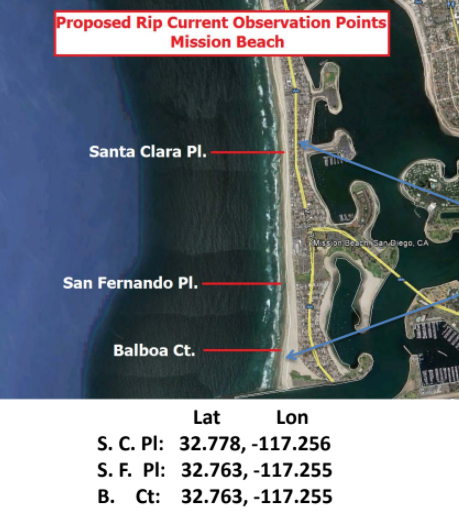
" alt="Alternative text" />
    <figcaption>Figure. The study site is the San Diego Weather Forecast Office, and specifically, rip current detection at Balboa Court, situated along popular Mission Beach.</figcaption>
</figure

### 3.1 Load modules
We start by installing the windrose package and loading the required modules for performing the data retrieval, visualization and modeling.

In [ ]:
# sys provides access to system level information (i.e., the executable for the Python installation)
import sys
# subprocess makes system level calls
import subprocess

# List of packages used in this notebook
PACKAGES = ["numpy", "windrose", "pandas", "tensorflow", "sklearn"]

# Loop through each package to either import or install
for package in PACKAGES:
    if package == 'sklearn': package = 'scikit-learn'
    try:
        # First, attempt to import the package
        __import__(package)
    except ImportError:
        # If package import is unsuccessful, install using pip
        # The command structure is <python executable> -m pip install <package>
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

In [ ]:
# import packages for downloading data from Zenodo
import requests, zipfile, io

# import packages for data analysis and machine learning model development
import numpy as np
import pandas as pd
import random as rn

import tensorflow as tf
print('Running on Tensorflow '+tf.__version__)  # Must be Tensorflow 2.x
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from statsmodels.tsa.tsatools import lagmat

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from windrose import WindroseAxes
from pandas.plotting import scatter_matrix

matplotlib.rc_file_defaults()

We also set random seeds, so that our results will be reproducible.

In [ ]:
np.random.seed(2)
tf.random.set_seed(4)
rn.seed(2)

### 3.2 Data retrieval
We now retrieve the data that will be used in this modeling exercise. This includes (a) the San Diego lifeguard reports of rip current occurrence, (b) the metocean observations from the nearby [NDBC 46258 wave buoy](https://www.ndbc.noaa.gov/station_page.php?station=46258), and (c) water level observations at the NOAA CO-OPS station [9410230 La Jolla, CA](https://tidesandcurrents.noaa.gov/stationhome.html?id=9410230). All of these data sources are read into Pandas dataframes, and some inititial date handling is applied. After reading these, we print out the first five lines of the data sets to start building an understanding what information they contain. In the lifeguard reports, we see the categorical rip current observations 'Rip Current Activity' for each of three lifeguard stations. In the wave buoy data, we see observations of significant wave height (WVHT, in m), dominant/peak wave period (DPD, in s), mean wave period (APD, in s), and mean wave direction (MWD, in degrees TN). In the CO-OPS data, we see the observed water level (WL, in m) relative to mean sea level (MSL). Time in both the wave data and water level data is in UTC, while time in the lifeguard records in local Pacific Time.

All data used in the notebook is stored in this Zenodo record ([https://doi.org/10.5281/zenodo.13741703](https://doi.org/10.5281/zenodo.13741703)).

In [ ]:
# Downloading the data from Zenodo record
url = 'https://zenodo.org/api/records/13741703/files-archive'
with zipfile.ZipFile(io.BytesIO(requests.get(url).content)) as zfile:
  zfile.extractall()

In [ ]:
# Read the lifeguard report database
print('Reading lifeguard report')
reports_raw = pd.read_csv('mission_beach_rip_current_reports_v4_corrected.csv', header='infer')
print(reports_raw.head(5))

In [ ]:
# Read wave obs data (NDBC 46258 - CDIP 220)
wavdat = pd.DataFrame(columns=['Date','WVHT','DPD','APD','MWD'])
for y  in range(2016,2021):
    year=str(y)
    print('Reading NDBC 46258 for '+year)
    df = pd.read_csv("46258h"+year+".txt", usecols=['#YY','MM','DD','hh','mm','WVHT','DPD','APD','MWD'],
                     skiprows=[1], delim_whitespace=True,na_values=[99.00,999.0])
    df = df.rename(columns={'#YY':'YY'})
    #Creating a consistent datetime to use accross variables
    df['Date'] = pd.to_datetime(df['YY'].astype(str)+df['MM'].astype(str).str.zfill(2)+df['DD'].astype(str).str.zfill(2)+' '+df['hh'].astype(str).str.zfill(2)+df['mm'].astype(str).str.zfill(2), format='%Y%m%d %H%M',utc=True)
    #Concat the years together
    wavdat = pd.concat([wavdat,df],join="inner")
print(wavdat.head(5))

In [ ]:
# Read water level obs data (9410230 La Jolla, CA)
wlvdat = pd.DataFrame(columns=['Date','WL'])
for y in range(2016,2021):
    year=str(y)
    print('Reading CO-OPS 9410230 for '+year)
    df = pd.read_csv("CO-OPS_9410230_met_"+year+".csv", usecols=['Date','Time (GMT)','Verified (m)'],
                     na_values=[99.00,999.0])
    df = df.rename(columns={'Date':'PDY','Verified (m)':'WL'})
     #Creating a consistent datetime to use accross variables
    df['Date'] = pd.to_datetime(df['PDY'].astype(str)+' '+df['Time (GMT)'].astype(str).str.zfill(2), format='%Y/%m/%d %H:%M',utc=True)
    #Concat the years together
    wlvdat = pd.concat([wlvdat,df],join="inner")
print(wlvdat.head(5))

As an initial check, we visualize the raw wave observations using wave height and period roses. We see a wave climate of longer period waves, arriving from the S-W sector.

In [ ]:
plt.figure()
ax = WindroseAxes.from_ax()
ax.bar(wavdat['MWD'], wavdat['WVHT'], normed=True, opening=0.8, edgecolor='white')
ax.legend(fontsize=18, loc='lower right')
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.title('NDBC 46258 - Sign. wave height (m)', fontsize=18)

plt.figure()
ax = WindroseAxes.from_ax()
ax.bar(wavdat['MWD'], wavdat['DPD'], normed=True, opening=0.8, edgecolor='white')
ax.legend(fontsize=18, loc='lower right')
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.title('NDBC 46258 - Dom. wave period (s)', fontsize=18)

We visualize the raw water level observations using a histogram. It shows an approximately normal, but somewhat asymmetrical, distribution. Though the water level is relative to mean sea level and thus centered close to 0, the mean water level is slightly shifted above 0. This is due to the amount of relative sea level rise at this location since the center of the last tidal datum epoch (1993), which is when the baseline 0 MSL is calculated.

In [ ]:
plt.figure(figsize=[4,3])
plt.hist(wlvdat['WL'], bins=50, histtype='step')
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('Water Level (m, MSL)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('CO-OPS 9410230', fontsize=12)

### 3.3 Data selection and cleaning
For this modeling exercise, we will not need all of the information contained in these files, and therefore select only the relevant data here. We will also clean and prepare the data for the ML models.

#### Lifeguard Observations
Starting with the lifeguard observations, the relevant information includes the observation date and time, and the reported rip current activity at the Bilboa Ct. lifeguard station. For simplicity, the column name is shortened. These lifeguard observations are categorical data. For our ML models, we need to turn these categories into equivalent numerical labels. We clean the data by dropping any records that have missing data (NaNs). The lifeguard reports were collected in local time (Pacific Time), so that the time stamps need to be corrected to a common UTC basis for modeling purposes.

In [ ]:
reports = reports_raw[['Observation Date',
                       'Observation Time','Rip Current Activity [Balboa Ct.]']]
#Renaming to shorten column names
reports = reports.rename(columns={"Rip Current Activity [Balboa Ct.]": "Balboa"})

#Changing the written description to a categorical numerical variable (0,1,2,3)
reports = reports.replace('No rips present', 0)
reports = reports.replace('Some low intensity rip currents present, may be hazardous to some swimmers', 1)
reports = reports.replace('Medium to strong rip currents present, will likely be hazardous to swimmers', 2)
reports = reports.replace('Very strong rip currents present, hazardous conditions', 3)
reports = reports.dropna()
reports.Balboa = reports.Balboa.astype(int)

#Formatting the datetime
reports['Date'] = pd.to_datetime(reports['Observation Date'].astype(str)+' '+reports['Observation Time'].astype(str),format='%m/%d/%Y %I:%M %p')
#Set the datetime of the dataframe to local and then convert to UTC
reports['Date'] = reports['Date'].dt.tz_localize('US/Pacific').dt.tz_convert('UTC')

reports = reports[['Date','Balboa']]

print(reports.shape)
print(reports.head(10))

The data selection and cleaning of the lifeguard observations is concluded by checking the statistical summary of the data set. We see that there are 1,510 rip current observations (data frame rows), which are recorded at either 18:00/19:00 UTC or 22:00/23:00 UTC (depending on daylight savings). The categorical rip current observations are now encoded as integers, with a majority class of 2, denoting "Medium to strong rip currents present, will likely be hazardous to swimmers".

In [ ]:
print(reports.describe())
print('\nClass distribution at Balboa:')
print(reports["Balboa"].value_counts())

We visualize this categorical rip current occurence data using bar charts.

In [ ]:
plt.figure(figsize = [3.5, 3.5])
ax = reports['Balboa'].value_counts().loc[[0, 1, 2, 3]].plot.bar(rot=0, color='blue', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
ax.set_xticklabels( ("none", "low", "medium", "strong") )
plt.title('Balboa Ct. Rip current strength')

As you can see, we have very few "none" cases of rip currents. Since the description of a 1 or "low" intensity rip current is one that might not be hazardous to most swimmers, it may make sense to combine the "none" and 1 as the "no" or 0 case and the medium (2) and strong (3) as the "yes" or 1 case. This will change the observations from a mult-category to a binary data set, which enables a probabilistic prediction of hazardous rip currents, as we will only be predicting a yes/no outcome.  This is a similar process to what was used when training the NOAA rip current model and can simplify our problem while creating a more robust set of targets.

This creates our final classification label 'Balboa_binary'. From the mean of this labelled data, we can see that hazardous rip currents (categories 2 and 3) occur 58.3% of the time at Balboa Ct.

In [ ]:
#The yes or 1 case of hazardous rip current occurrence
reports.loc[(reports.Balboa >=2),'Balboa_binary'] = 1
#The no or 0 case of  hazardous rip current occurrence
reports.loc[(reports.Balboa < 2),'Balboa_binary'] = 0
reports.Balboa_binary = reports.Balboa_binary.astype(int)

print(reports.describe())

#### Wave and water level observations

Next, we perform data selection, cleaning and feature engineering on the wave water level observations. A first step is to check for completeness of the data records.  Since we will be potentially using some lagged variables, it is first helpful to check if there are any gaps in the data sets.  We can do a quick check on this by looking at the time difference between data records.

First we check wave data.

In [ ]:
#Change the datetime into a integer and divide by 10^9 to shift it to seconds
waveCheck = np.diff(wavdat['Date'].astype(int)) / 10**9

#plot to see if there is missing data, if not we should have a straight line at 1800 seconds (30 minutes between observations)
plt.plot(waveCheck)

This makes it pretty clear that there are a bunch of data gaps, some of them fairly large.

Now lets try the water level data. If this is a continuous data set, it should be a straightline at 3600 seconds (60 minutes between observations)

In [ ]:
#Change the datetime into a integer and divide by 10^9 to shift it to seconds
wlvCheck = np.diff(wlvdat['Date'].astype(int)) / 10**9

#plot to see if there is missing data, if not we should have a straight line at 1800 seconds (30 minutes between observations)
plt.plot(wlvCheck)

So, our water level data is complete with no gaps, while the wave data is not. That won't be a huge problem with the ML models since we can just remove the time series steps with missing data. However, we want to create some time-lagged variables which might be useful for ML model development. The easiest way to do this in this case is just to merge the two data sets to use the same datetime as the water level observations.  This will create a consistent, hourly data set, with NaNs enterered where there is missing wave data.

In [ ]:
# merge wavedat and wlvdat into one dataframe called wav_wlv
wav_wlv = pd.merge(wavdat, wlvdat, on='Date', how='right')

print(wav_wlv)

The wave and water level data is now on a continuous hourly data record.  Now we want to do some feature engineering. First, an "event index" to account for the potential influence of past wave events on the nearshore bathymetry is calculated. This index is set to 1 if a storm wave height of 1m or more occurred anytime in the previous 72 hours.

Next, we apply a log transform to the signficant wave height, which was found in Dusek and Seim (2013) to result in improved model performance.

Lastly, the wave direction is converted to an absolute deviation from shore normal (waves arriving straight onshore), which was similarly found to improve model fit. In this case this done by shifting the wave direction by 270 degrees, since Mission Beach is oriented roughly North-South, meaning waves from due west (270 degrees) are arriving straight onshore.

In [ ]:
# Compute event index by creating a new lagged matrix and looking back for any wave events exceeding 1m
WVHT_lag72h = lagmat(wav_wlv['WVHT'], maxlag=72, trim="forward", original='in')
EP = np.any(WVHT_lag72h[:,1:]>=1.00, axis=1).astype(int)
wav_wlv.insert(5, 'EP', EP)

# Apply a log transform to WVHT
wav_wlv['WVHT'] = np.log(wav_wlv['WVHT'])

# Convert MWD to a deviation from shore normal
wav_wlv['MWD'] = wav_wlv['MWD'].astype(float)
wav_wlv['MWD'] = np.abs(wav_wlv['MWD']-270.)

#Printing a middle few records to ensure the transformations look correct when wave data is present
print(wav_wlv[1000:1010])

We also compute lagged wave and water level parameters of 1,2 and 3 hours, which could be beneficial to account for contributions of wave and water levels over time.

In [ ]:
#Calculating lags of up to three hours for each of the variables (except for the newly created EP)
#Then inserting them into the original dataframe for future use

WVHT_lag = lagmat(wav_wlv['WVHT'], maxlag=3, trim="forward", original='in')
wav_wlv.insert(2, 'WVHT_lag1', WVHT_lag[:,1])
wav_wlv.insert(3, 'WVHT_lag2', WVHT_lag[:,2])
wav_wlv.insert(4, 'WVHT_lag3', WVHT_lag[:,3])
DPD_lag = lagmat(wav_wlv['DPD'], maxlag=3, trim="forward", original='in')
wav_wlv.insert(6, 'DPD_lag1', DPD_lag[:,1])
wav_wlv.insert(7, 'DPD_lag2', DPD_lag[:,2])
wav_wlv.insert(8, 'DPD_lag3', DPD_lag[:,3])
APD_lag = lagmat(wav_wlv['APD'], maxlag=3, trim="forward", original='in')
wav_wlv.insert(10, 'APD_lag1', APD_lag[:,1])
wav_wlv.insert(11, 'APD_lag2', APD_lag[:,2])
wav_wlv.insert(12, 'APD_lag3', APD_lag[:,3])
MWD_lag = lagmat(wav_wlv['MWD'], maxlag=3, trim="forward", original='in')
wav_wlv.insert(14, 'MWD_lag1', MWD_lag[:,1])
wav_wlv.insert(15, 'MWD_lag2', MWD_lag[:,2])
wav_wlv.insert(16, 'MWD_lag3', MWD_lag[:,3])
WL_lag = lagmat(wav_wlv['WL'], maxlag=3, trim="forward", original='in')
wav_wlv.insert(19, 'WL_lag1', WL_lag[:,1])
wav_wlv.insert(20, 'WL_lag2', WL_lag[:,2])
wav_wlv.insert(21, 'WL_lag3', WL_lag[:,3])
print(wav_wlv[1000:1010])
print(wav_wlv.describe())

Finally, we merge wave and water level data with the rip current observatsions into a single data set to be used in our modeling. This merging is done via a database operation called an inner join, in which only the records (observation time stamps) that are common to all the sources are retained. As a result, only records at 18:00/19:00 UTC and 22:00/23:00 UTC are retained, being the only times at which rip current, wave and water level observations are available concurrently.

Since there are many missing wave data points that were previously filled with NaNs in our wave and water level merge previously, we also want to drop any rows with NaN entries to ensure every timestep included has a complete data record.

From the data summary, we see that this reduces the final assembled data set to 833 records.

In [ ]:
# Merge the wave and water level data with the rip current observations
ripdata = pd.merge(wav_wlv, reports, on='Date', how='inner')
ripdata.set_index('Date', inplace=True)

#Drop any rows with any NaN entries, since these cannot be used as-is for modeling
ripdata.dropna(inplace=True)

print(ripdata.head(10))
print(ripdata.describe())

### 3.4 Data visualization
With the data set assembled, we create a scatterplot matrix to better understand the data and correlations. Recall that we identified rip current reports with categories 2 and 3 as hazardous rip current events (Balboa_binary = 1), and categories 0 and 1 as non-events (Balboa_binary = 0). Using the scatterplot matrix, we can investigate wave and water level conditions that lead to these dangerous conditions by color-coding hazardous rip current events red and non-events blue.

In [ ]:
colors=['blue','red']

plt.figure()
scatter_matrix(ripdata[['WVHT','DPD','APD','MWD','WL']], alpha = 0.5, figsize = (7, 7),
               diagonal = 'kde', s=8, c=ripdata.Balboa_binary.apply(lambda x:colors[x]))

### 3.5 Data partitioning
To build our ML models, we have to partition the data set into training and test partitions. Since this is time series data, we select the training data from a continuous period, namely 2016-2018. The data from 2019-2020 is selected for the test partition. Because the former period is denser with lifeguard records, the training set contains 579 observations (70% of data) and the test set 254 (30% of data).

In [ ]:
#The variables we initially want to try as our features
X = ripdata[['WVHT','DPD','MWD','WL','EP']]
#The variable we are trying to predict or the target
y = ripdata[['Balboa_binary']]

#Using this date a cutoff between training and testing
train_index = X.index < '2019-01-01 00:00:00'
test_index = X.index >= '2019-01-01 00:00:00'

X_train = X[train_index].to_numpy()
X_test = X[test_index].to_numpy()
y_train = y[train_index].to_numpy().ravel()
y_test = y[test_index].to_numpy().ravel()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

### 3.6 Model building
In this section, we will build various binomimial classication models for predicting hazardous rip currents. For each model type (logistic regression, dense neural net), we will follow the same procedure:
- Fit model using the training data partition.
- Predict the results of the test partition.
- Create a Receiver Operator Curve (ROC) from the predicted probabilities and observed rip currents.
- Select candidate with best Area Under Curve (AUC) as the best classifier for that model type.
- Select optimum probability threshold for identifying rip events, by considering the confusion matrix, precision, and recall.

#### Model 1: Majority class model
As our baseline model we select simple climatology, or the so-called majority class model. This reference model simply always predicts the majority class, and thus its accuracy is the frequency of occurrence of this class. In our case, the frequency of the non-event is slightly greater than 0.5 in the test partition, so the accuracy of our majority class model is 0.512 (or 51.2%). This sets up the target accuracy to be beat with our candidate models.

In [ ]:
print('Number of rip events (test data): %.3f' % y_test.sum() )
print('Number of non-events (test data): %.3f' % (len(y_test) - y_test.sum()) )
majority_class_acc = 1.-float(y_test.sum())/float(len(y_test))
print('--- Majority class model ---')
print('> Test Accuracy: %.3f' % majority_class_acc)

#### Model 2: Logistic Regression
As our first candidate model, we will build a logistic regression model. This is the type of model used for the NOAA rip current model. We start by training the model for all five predictors, but we see that DPD (x2) and the event parameter EP (x5) are not significant (p-values > 0.05). From the ROC we see that this classifier has an AUC = 0.778.

In [ ]:
import statsmodels.api as sm
import statsmodels.tools as st
from sklearn import preprocessing

#This step standardizes the data by demeaning and scaling to unit variance by calculating a standard scaler
#and applying to the train and test data
scaler = preprocessing.StandardScaler().fit(X.values)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = st.tools.add_constant(X_train_scaled, prepend=True, has_constant='skip') # Add column for intercept
X_test_scaled = st.tools.add_constant(X_test_scaled, prepend=True, has_constant='skip') # Add column for intercept

logit_model1=sm.Logit(y_train,X_train_scaled).fit()
print(logit_model1.summary())
yhat = logit_model1.predict(X_test_scaled)

# Compute ROC curve and area under curve (AUC)
n_outputs = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[4,3])
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.text(0.6, 0.15, 'AUC ='+'{0:.3f}'.format(roc_auc), fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balboa: ROC curve - Logistic Regression')

Next, we try a second model with only the predictors that were found to be significant: WHVT, MWD and WL. We select these columns and then refit the model. From the resulting ROC, we see that this model is somewhat better, indicated by a slightly larger AUC of 0.782. We will choose this as our final logistic regression model.

In [ ]:
# Select constant (0) and WVHT (x1), MWD (x3) and WL (x4) only
X_train_scaled = X_train_scaled[:,[0,1,3,4]]
X_test_scaled = X_test_scaled[:,[0,1,3,4]]

logit_model1=sm.Logit(y_train,X_train_scaled).fit()
print(logit_model1.summary())
yhat = logit_model1.predict(X_test_scaled)

# Compute ROC curve and area under curve (AUC)
n_outputs = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[4,3])
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.text(0.6, 0.15, 'AUC ='+'{0:.3f}'.format(roc_auc), fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balboa: ROC curve - Logistic Regression')

Having selected our logistic regression model, we now need to select a probability threshold value to identify positive cases (hazardous rip current events). As in the optional toy example, we will select this threshold by balancing precision and recall, given the skill of our classification model expressed in its ROC curve. A low threshold will yield high recall, but low precision, whereas a high threshold will yield lower recall, but higher precision. Our first try is with a threshold of P = 0.5. This yields an F1 score of 0.701, and the accuracy of 0.606 is higher than our majority call model (0.512), indicating predictive skill.

In [ ]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.5

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Logistic regression model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

Next, we try a threshold of P = 0.85. At this threshold the accuracy improves to 0.728, but the F1 score drops to 0.679. Most impoprtantly, using the 0.85 threshold results in a significantly lower recall of 0.589. This means over 40% of hazardous rip current cases would go by undetected, which is not ideal for a potentially life threatening event.

In [ ]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.85

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Logistic regression model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

Finally, we try a threshold of 0.75. This yields the highest F1 score of the three investigated thresholds (0.731), while maintaining an accuracy score of 0.724 and a recall of 0.766. This accuracy score is much higher than that of the majority class model (0.512), indicating that our final logistic regression model has predictive skill. We set this model version as our best logistic regression candidate.

In [ ]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.75

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Logistic regression model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

best_logistic_acc = acc
best_logistic_precision = precision
best_logistic_recall = recall
best_logistic_f1_score = f1_score

#### Model 3: Dense Neural Network
As our second candidate model, we will build a dense neural network. This model achieves an AUC = 0.750, which is somewhat poorer than those of the logistic regression models.

In [ ]:

#Define the neural network we are using, in this case it has 3 dense hidden layers with 8 neurons each and a dense output layer
#We also include l2 regularization to reduce overfitting
def get_model(n_inputs, n_outputs):
   model = models.Sequential()
   model.add(layers.Dense(8, input_dim=n_inputs, kernel_initializer='he_uniform',
                           activation='relu', bias_regularizer=regularizers.l2(0.1)))
   model.add(layers.Dense(8, bias_regularizer=regularizers.l2(0.1)))
   model.add(layers.Dense(8, bias_regularizer=regularizers.l2(0.1)))
   model.add(layers.Dense(n_outputs, activation='sigmoid'))
   model.compile(loss='binary_crossentropy', optimizer='adam')
   return model

# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
   results = list()
   tn = list()
   fp = list()
   fn = list()
   tp = list()
   n_inputs, n_outputs = X.shape[1], 1
   print(n_inputs, n_outputs)
   # define evaluation procedure
   cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
   # enumerate folds
   for train_ix, test_ix in cv.split(X):
      # prepare data
      X_train, X_test = X[train_ix], X[test_ix]
      y_train, y_test = y[train_ix], y[test_ix]
      # define model
      model = get_model(n_inputs, n_outputs)
      # fit model
      model.fit(X_train, y_train, verbose=0, epochs=500)
      # make a prediction on the test set
      yhat = model.predict(X_test)

      # round probabilities to class labels
      yhat = yhat.round()
      # calculate accuracy
      acc = accuracy_score(y_test, yhat)
      tneg, fpos, fneg, tpos = confusion_matrix(y_test, yhat).ravel()
      # store result
      print('>%.3f' % acc)
      results.append(acc)
      tn.append(tneg)
      fp.append(fpos)
      fn.append(fneg)
      tp.append(tpos)
   return model, results, tn, fp, fn, tp

# Build and evaluate model
model, results, tn, fp, fn, tp = evaluate_model(X_train, y_train)
model.summary()

# Test the model performance
yhat = model.predict(X_test)

# Compute ROC curve and area under curve (AUC)
n_outputs = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[4,3])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.text(0.6, 0.15, 'AUC ='+'{0:.3f}'.format(roc_auc), fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balboa: ROC curve - Dense NN model (test data)')

Having selected our dense neural network model, we now need to select a probability threshold value to identify positive cases (hazardous rip current events). We start with a threshold of P = 0.5. This yields an F1 score of 0.676, and a recall of 0.968. The accuracy score of 0.547 is only slightly higher than that of the majority class model (0.512), indicating only minimal skill.

In [ ]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.50

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Dense NN model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

Next, we try a threshold of P = 0.75, following our choice for the Logistic Regression Model. We see that the F1 score improves to 0.697, and while the accuracy increases substantially to 0.661, it is still a bit lower than our logistic regression model (accuracy of 0.724). Recall reduces to 0.798, however this is similar to what we saw with our logistic regression model at the same threshold. We set this model version to the best dense neural net candidate.

In [ ]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.75

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Dense NN model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

best_nn_acc = acc
best_nn_precision = precision
best_nn_recall = recall
best_nn_f1_score = f1_score

### 3.7 Model intercomparison
In the modeling section above we built several logistic regression and dense neural net models. In this section we compare their results, to make our final selection of best classification model to predict hazardous rip currents. From this comparison, we see that the best logistic regression model performs somewhat better overall than the best dense neural net model, and would thus be our final model of choice.

In [ ]:
print('--- Majority class model ---')
print('Accuracy: %.3f' % majority_class_acc)

print('\n--- Best logistic regression model ---')
print('Accuracy: %.3f' % best_logistic_acc)
print('Precision: %.3f' % best_logistic_precision )
print('Recall: %.3f' % best_logistic_recall )
print('F1_score: %.3f' % best_logistic_f1_score )

print('\n--- Best dense NN model ---')
print('Accuracy: %.3f' % best_nn_acc)
print('Precision: %.3f' % best_nn_precision )
print('Recall: %.3f' % best_nn_recall )
print('F1_score: %.3f' % best_nn_f1_score )



---


## Exercises
Using the classification models we built above, try the following:
* Select different sets of predictors, for example using lagged variables. Are these statistically significant? Do they improve the quality of the classifiers in terms of the AUC?
* Experiment with different probabiltiy thresholds for identifying events. How does the trade-off between recall and precision change? What do you think would be the best balance of these metrics for forecasting the rip current hazard?

## Examples in NOAA

In NOAA operations, a logisitic regression model similar to the one trained above is used for the prediction of hazardous rip currents. The model has been trained by Dusek and Seim (2013) to:

$P\left( y = 1 \lvert g(x) \right) = \dfrac{1}{1+ e^{-g(x)}}$

$g(x) = 1.05 + 3.51\ln(\mathrm{WVHT}) - 0.027\lvert\mathrm{MWD}\rvert + 0.42E_p - 1.70\mathrm{WL}$

Unlike in the tutorial, the input to this classification model is numerical model predictions of significant wave height, mean wave direction, water levels, and the event parameter computed by NOAA's Nearshore Wave Prediction System (NWPS) and Extratropical Surge Operational Forecast System (ESTOFS). This allows the prediction of hazardous rip currents up to 6 days into the future. Thousands of instances of this point-based model have been deployed at 1000-2000 m intervals along U.S. coastlines within NWPS. In the link below, these rip current classifications in three classes (gray=low, yellow=moderate, red=high) are shown. Zoom in and click on an output location to view a time series of the rip current probability for each 6 day forecast:

https://polar.ncep.noaa.gov/nwps/viewer.shtml

## Data statement

All data used in this notebook is available as included csv and text files. If users would like to utilize similar data sets for their own models, please see the sources here for more information.

The wave observations used in this example can be found at the NOAA National Data Buoy Center (NDBC) website: https://www.ndbc.noaa.gov/, with the specific example from the [NDBC 46258 wave buoy](https://www.ndbc.noaa.gov/station_page.php?station=46258)

The water level observations used in this example can found at the NOAA NOS Center for Operational Oceanographic Products and Services (CO-OPS), using their data API at: https://tidesandcurrents.noaa.gov/api-helper/url-generator.html, with the specific example here from station [9410230 La Jolla, CA](https://tidesandcurrents.noaa.gov/stationhome.html?id=9410230)  

Rip current observations were collected by the San Diego Lifeguards at Mission Beach in San Diego, CA.  These are stored by NWS Meteorological Development Lab and available upon request.

## References

[Dusek, G. and H. Seim (2013).  A probabilistic rip current forecast model.  Journal of Coastal Research.  29(4).  909-925.](https://www.researchgate.net/publication/260178309_A_Probabilistic_Rip_Current_Forecast_Model)

## Metadata
 * Language / package(s): Python, tensorflow, scikit-learn, windrose, numpy, matplotlib
 * Domain: weather, coast
 * Application keywords: rip current
 * Geophysical keywords: California
 * AI keywords: logistic regression

## Disclaimer
This Jupyter notebook is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Google CoLab Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Google CoLab Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.